In [3]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
import findspark
findspark.init()
from pyspark.sql import SparkSession

In [4]:
spark = SparkSession.builder.master("local[2]").appName('recommendation').getOrCreate()

In [5]:
la = pd.read_csv("../scraper/la_restaurant.csv")
sd = pd.read_csv('../scraper/san_diego_restaurant.csv')
df = la.append(sd)

# Data Cleaning, Wrangling and Prepping

In [6]:
df['rating'] = df['rating']/10
df = df[~df['restaurant'].str.contains('http')]

### Cleaning rating, user, and restuarant data for ALS

In [7]:
from pyspark.sql.functions import monotonically_increasing_id, col, avg

In [8]:
df_spark = spark.createDataFrame(df)

In [9]:
df_spark.show(5)

+------------+------+--------------------+-------------+---------------+
|   user_name|rating|              review|         date|     restaurant|
+------------+------+--------------------+-------------+---------------+
|       Ray M|   5.0|My wife and I sto...|   March 2021|In-N-Out Burger|
|      Judy G|   5.0|We are at a time ...|   April 2020|In-N-Out Burger|
|  11dragon64|   5.0|A staple of our f...|   March 2020|In-N-Out Burger|
|      Yenyok|   4.0|The best Burger i...|February 2020|In-N-Out Burger|
|Comanderkody|   3.0|Went to the one o...|February 2020|In-N-Out Burger|
+------------+------+--------------------+-------------+---------------+
only showing top 5 rows



In [10]:
users = df_spark.select('user_name').distinct()
users = users.coalesce(1)
users = users.withColumn("user_id", monotonically_increasing_id()).persist()

In [11]:
users.show(5)

+-----------+-------+
|  user_name|user_id|
+-----------+-------+
|MarkLBoston|      0|
|  tripledec|      1|
|    TashW35|      2|
|   Rjcestra|      3|
|   Norman S|      4|
+-----------+-------+
only showing top 5 rows



In [12]:
rest = df_spark.select('restaurant').distinct()
rest = rest.coalesce(1)
rest = rest.withColumn('rest_id', monotonically_increasing_id()).persist()
rest.show(5)

+--------------------+-------+
|          restaurant|rest_id|
+--------------------+-------+
|      Randy's Donuts|      0|
|         Stack Shack|      1|
|      RoRo's Chicken|      2|
|Top Round Roast Beef|      3|
|    Daddy's Hot Dogs|      4|
+--------------------+-------+
only showing top 5 rows



In [13]:
df_ids = df_spark.join(users,"user_name","left").join(rest,'restaurant','left')
final_df = df_ids.select(col('user_id'), col('rest_id'),col('rating'))
final_df.show(5)

+-------+-------+------+
|user_id|rest_id|rating|
+-------+-------+------+
|   5897|     58|   5.0|
|   4304|     58|   5.0|
|  13731|     58|   5.0|
|  12620|     58|   4.0|
|   9601|     58|   3.0|
+-------+-------+------+
only showing top 5 rows



In [14]:
final_df = final_df.groupBy(['user_id','rest_id']).avg()
final_df = final_df.select(col('user_id'), col('rest_id'),col('avg(rating)').alias('rating'))

In [15]:
final_df.count()

22209

In [56]:
users_spark = final_df.groupBy('user_id').count().filter(col('count')>=3).select('user_id')
users_spark_list = list(users_spark.toPandas()['user_id'])

In [61]:
final_df = final_df[final_df.user_id.isin(users_spark_list)]

In [16]:
user_ratings = df.groupby(by=['user_name','restaurant'])['rating'].mean().to_frame().reset_index()
user_review_counts = user_ratings['user_name'].value_counts()
users = user_review_counts[user_review_counts>=3].index
users.shape

(828,)

In [60]:
user_ratings[user_ratings['user_name'].isin(users)]

user_name                    restaurant  rating
3      0221Serendipity               In-N-Out Burger     5.0
4      0221Serendipity  The Original Farmer's Market     5.0
5      0221Serendipity             Wetzel's Pretzels     4.0
84           162greigs                    City Tacos     5.0
85           162greigs         Cotija's Mexican Food     4.0
...                ...                           ...     ...
22089        wvillamil                Zankou Chicken     3.0
22149       yorkie1552                 Cafe Socrates     3.0
22150       yorkie1552                       Eggslut     5.0
22151       yorkie1552                 Panda Express     3.0
22152       yorkie1552                   Shake Shack     5.0

[3301 rows x 3 columns]

## Exploratory Data Analysis
---
### 1) Numerical Data 

### Ratings descriptive statistics across all restaurants

In [17]:
df['rating'].describe()

count    22810.000000
mean         4.266769
std          0.945851
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: rating, dtype: float64

### The amount of reviews per restuarant

In [18]:
df['restaurant'].value_counts().describe()

count     323.000000
mean       70.619195
std       180.450301
min         1.000000
25%        14.000000
50%        23.000000
75%        56.500000
max      2303.000000
Name: restaurant, dtype: float64

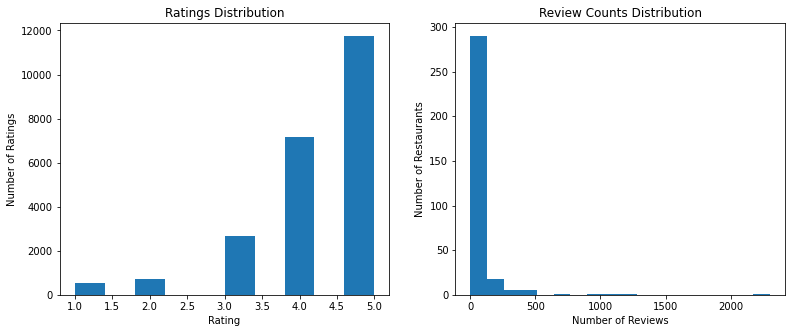

In [19]:
review_counts = df['restaurant'].value_counts()


fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(13,5))
axes[0].hist(df['rating'])
axes[0].set_title('Ratings Distribution')
axes[0].set_ylabel('Number of Ratings')
axes[0].set_xlabel('Rating')

axes[1].hist(review_counts, bins=18)
axes[1].set_title('Review Counts Distribution')
axes[1].set_ylabel('Number of Restaurants')
axes[1].set_xlabel('Number of Reviews')


plt.show()

- Ratings and review counts are skewd to the left. The average rating is is a 4.26 while the max is a 5. More popular restuarants get the majority of the reviews. This is confirmed by the the mean for review counts by restaurant is 70 despite a 56 count being the 75th percentile. 75 percent of restuarants have less than 75 percent of total reviews.

### 2) Categorical Plots

In [20]:
avg_rating_restaurant = df.groupby('restaurant')['rating'].mean()

In [21]:
top_by_count = df['restaurant'].value_counts().head(20)


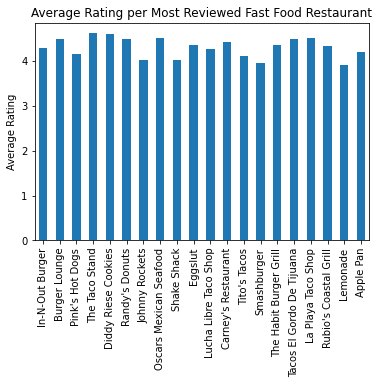

In [22]:
avg_rating_restaurant[top_by_count.index].plot.bar()
plt.title('Average Rating per Most Reviewed Fast Food Restaurant')
plt.ylabel('Average Rating')
plt.show()

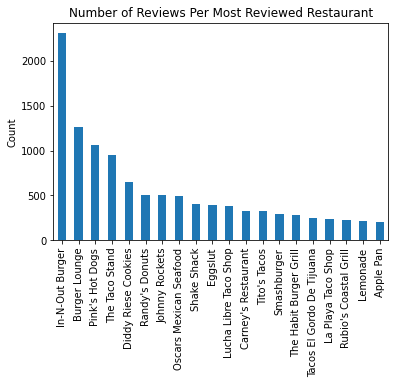

In [23]:
top_by_count.plot.bar()
plt.title('Number of Reviews Per Most Reviewed Restaurant')
plt.ylabel('Count')
plt.show()

# ALS

In [62]:
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

(train,test) = final_df.randomSplit([0.8,0.2])

als = ALS(userCol="user_id" , itemCol="rest_id", ratingCol="rating",coldStartStrategy="drop",
          nonnegative = True, implicitPrefs = False) 


param_grid = ParamGridBuilder().addGrid(als.rank,[5,10,20]).addGrid(als.maxIter, [5,10,15]).addGrid(als.regParam, [.05, .1, 1.5]).build()

evaluator = RegressionEvaluator(metricName='rmse',labelCol='rating',predictionCol='prediction')

cv = CrossValidator(estimator = als, estimatorParamMaps = param_grid, evaluator = evaluator, numFolds = 5)

model = cv.fit(train)


In [35]:
best = model.bestModel
predictions = best.transform(test)
rmse = evaluator.evaluate(predictions)

In [36]:
rmse

1.6133981857927955

In [63]:
best2 = model.bestModel
predictions2 = best2.transform(test)
rmse = evaluator.evaluate(predictions2)

In [64]:
rmse

1.2647357331114306